In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
selected_ev            = 2        # which Eigenvector to choose
ϵ                      = 0.2      # perturbation
t₀                      = 0.6     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

 17.535130 seconds (64.98 M allocations: 3.712 GiB, 6.17% gc time)


In [ ]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ)

In [8]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot);

 32.003453 seconds (56.00 M allocations: 4.314 GiB, 2.64% gc time)


In [34]:
# solve the linear system
@time λ₀s, u₀s = eigs(K, M, which=:SM)
@assert all(imag.(u₀s) .== 0)
@assert all(imag.(λ₀s) .== 0)
u₀s = real.(u₀s)
λ₀s = real.(λ₀s)
# normalize
for i in 1:size(u₀s)[2]
    u₀s[:,i] = u₀s[:,i] ./ sqrt(u₀s[:,i]'*M*u₀s[:,i])
    u₀s[:,i] = u₀s[:,i]*sign(sum(u₀s[:,i]))
end

  0.099604 seconds (994 allocations: 33.916 MiB)


In [35]:
# calculate the exact uϵ
λϵs, uϵs = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵs) .== 0)
@assert all(imag.(λϵs) .== 0)
uϵs = real.(uϵs)
λϵs = real.(λϵs)
# normalize
for i in 1:size(uϵs)[2]
    uϵs[:,i] = uϵs[:,i] ./ sqrt(uϵs[:,i]'*M*uϵs[:,i])
    uϵs[:,i] = uϵs[:,i]*sign(sum(uϵs[:,i]))
end

In [36]:
# solve the system for the derivative u_dot
u_dots = []
λ_dots = []
for i in 1:size(u₀s)[2] 
    lhs = [K-λ₀s[i]*M   -M*u₀s[:,i]
            u₀s[:,i]'*M      0]
    rhs = [-L*u₀s[:,i]    ;  0]

    @time b = lhs \ rhs
    push!(u_dots,b[1:end-1])
    push!(λ_dots,b[end])
end

  0.055618 seconds (75 allocations: 19.985 MiB)
  0.063554 seconds (77 allocations: 19.986 MiB, 10.56% gc time)
  0.056011 seconds (75 allocations: 19.985 MiB)
  0.055460 seconds (75 allocations: 19.985 MiB)
  0.065042 seconds (81 allocations: 19.986 MiB, 8.81% gc time)
  0.056866 seconds (75 allocations: 19.985 MiB)


In [40]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -3.1
cmax =     3.1
cmin_lr =  -10
cmax_lr =  10

10

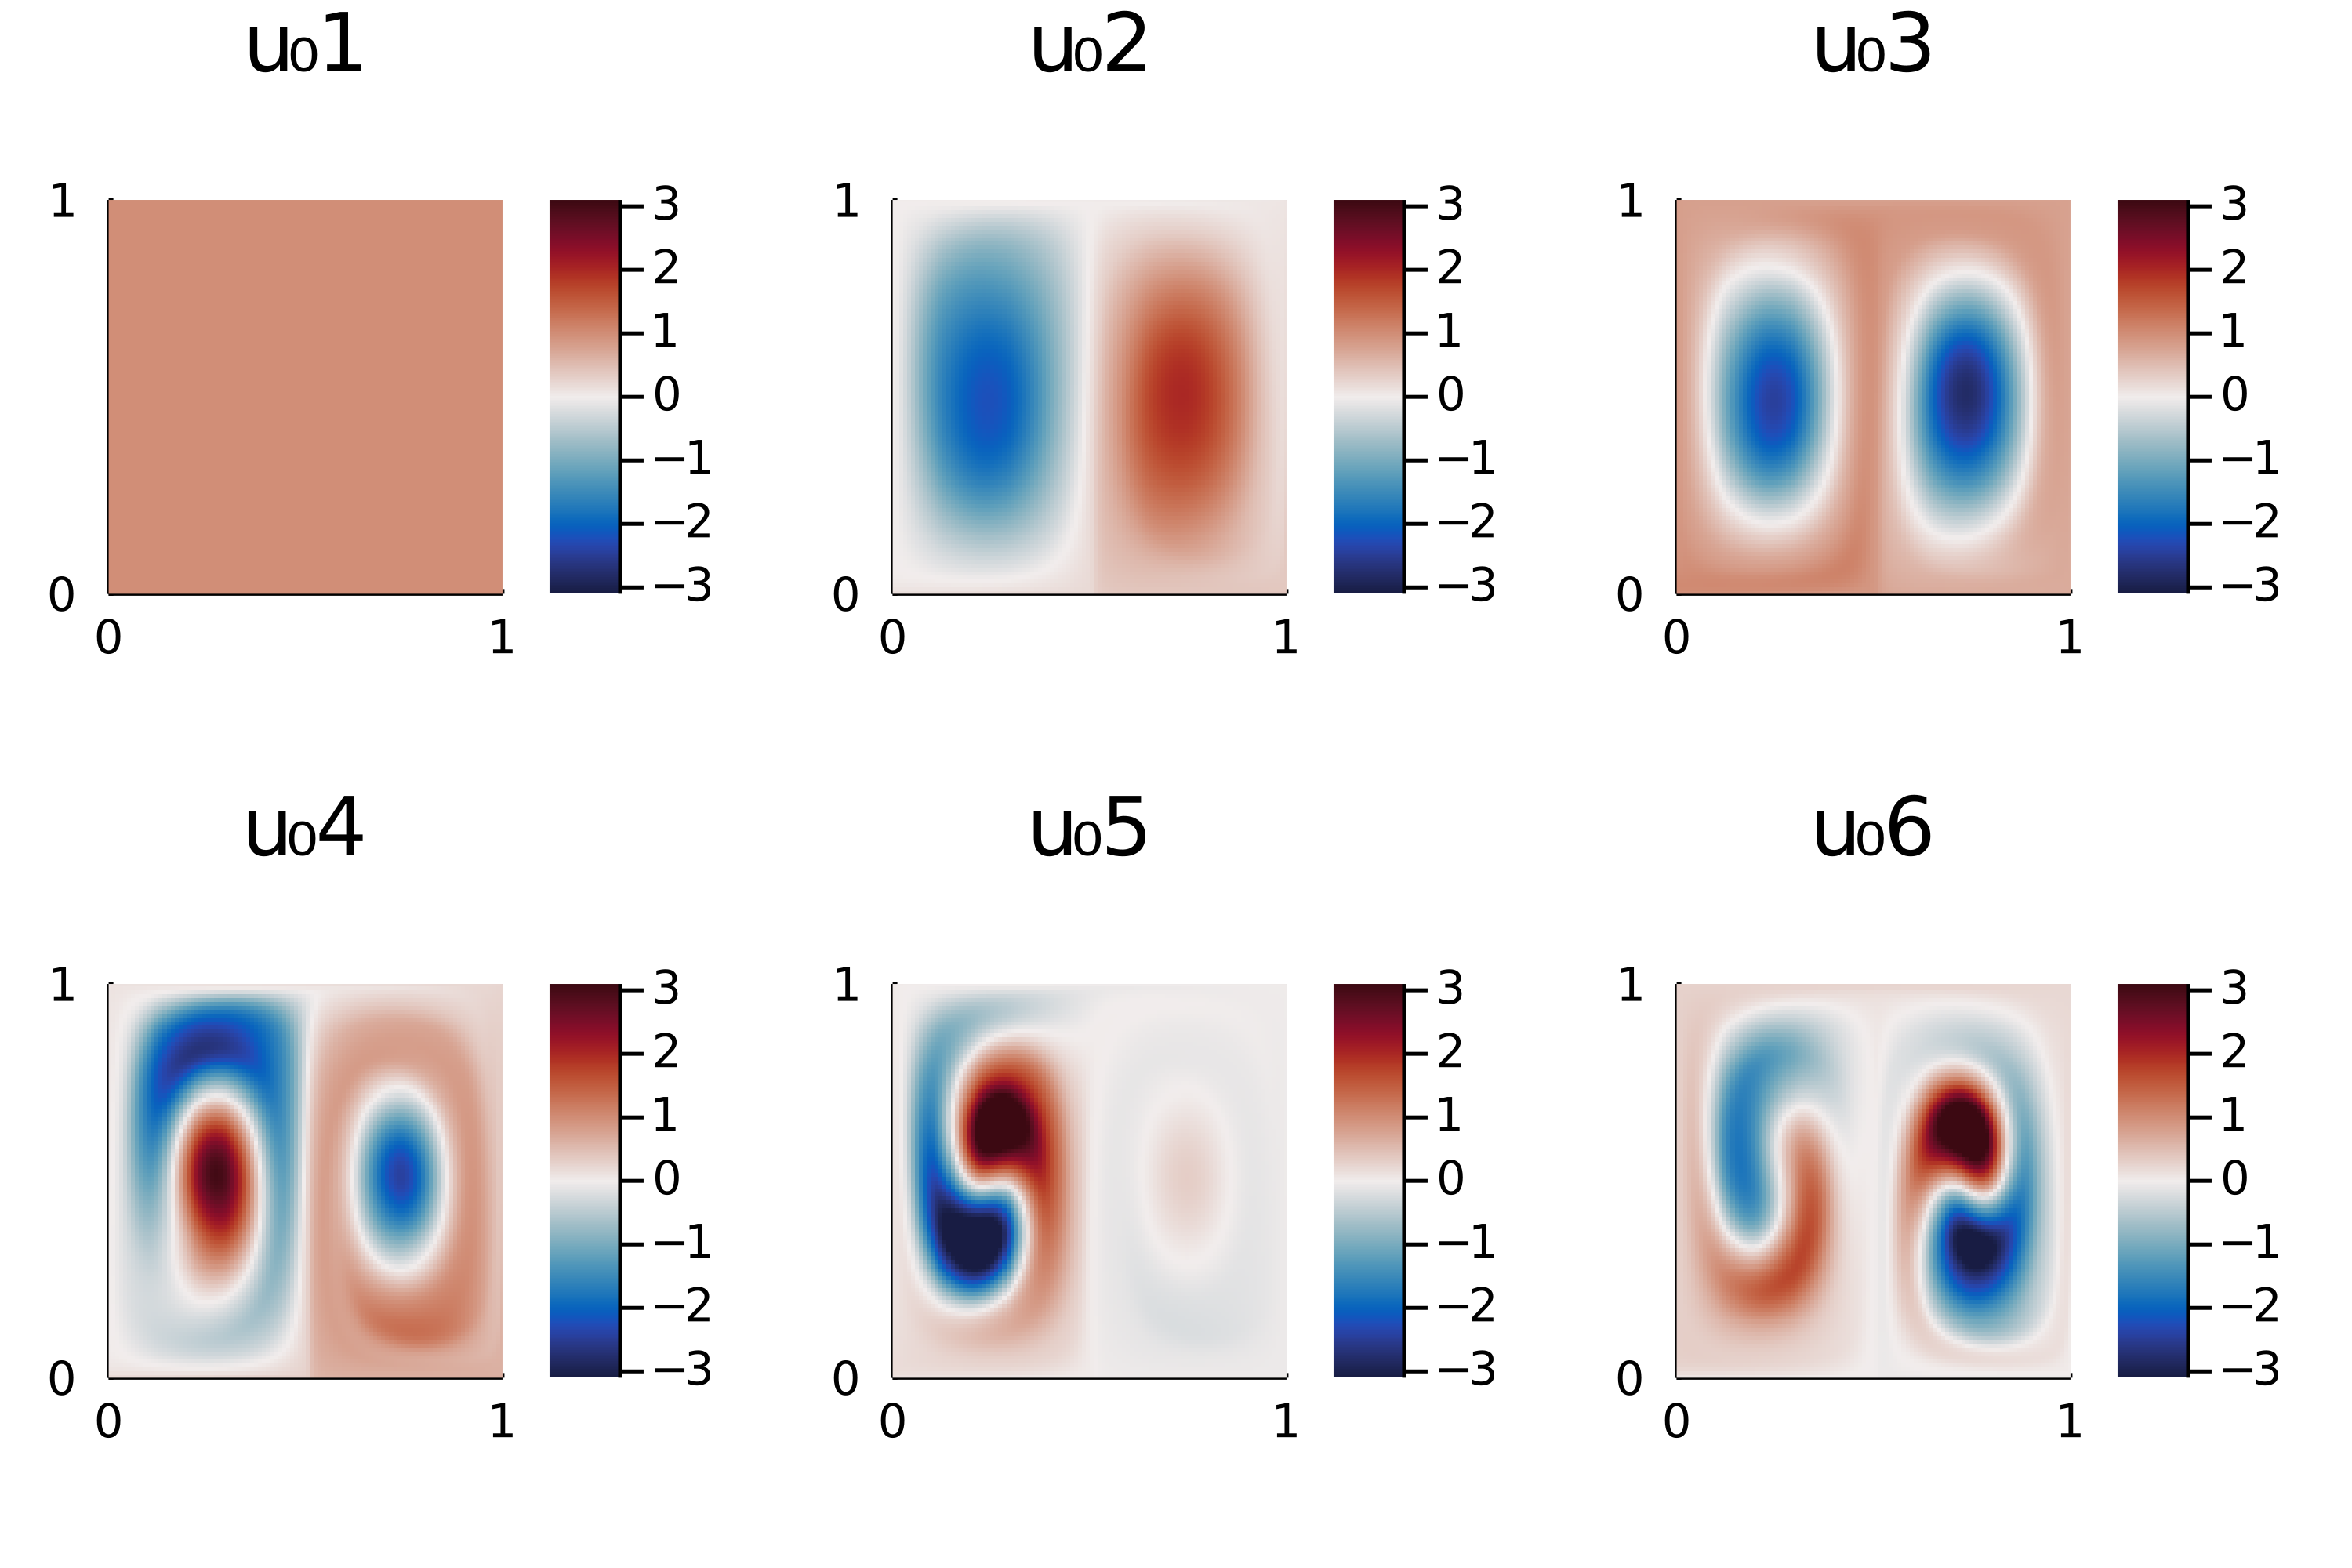

In [37]:
first         = plot_u(ctx, u₀s[:,1],  grid_resolution, grid_resolution, title="u₀1", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, u₀s[:,2],  grid_resolution, grid_resolution, title="u₀2", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, u₀s[:,3],  grid_resolution, grid_resolution, title="u₀3", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, u₀s[:,4],  grid_resolution, grid_resolution, title="u₀4", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, u₀s[:,5],  grid_resolution, grid_resolution, title="u₀5", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, u₀s[:,6],  grid_resolution, grid_resolution, title="u₀6", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

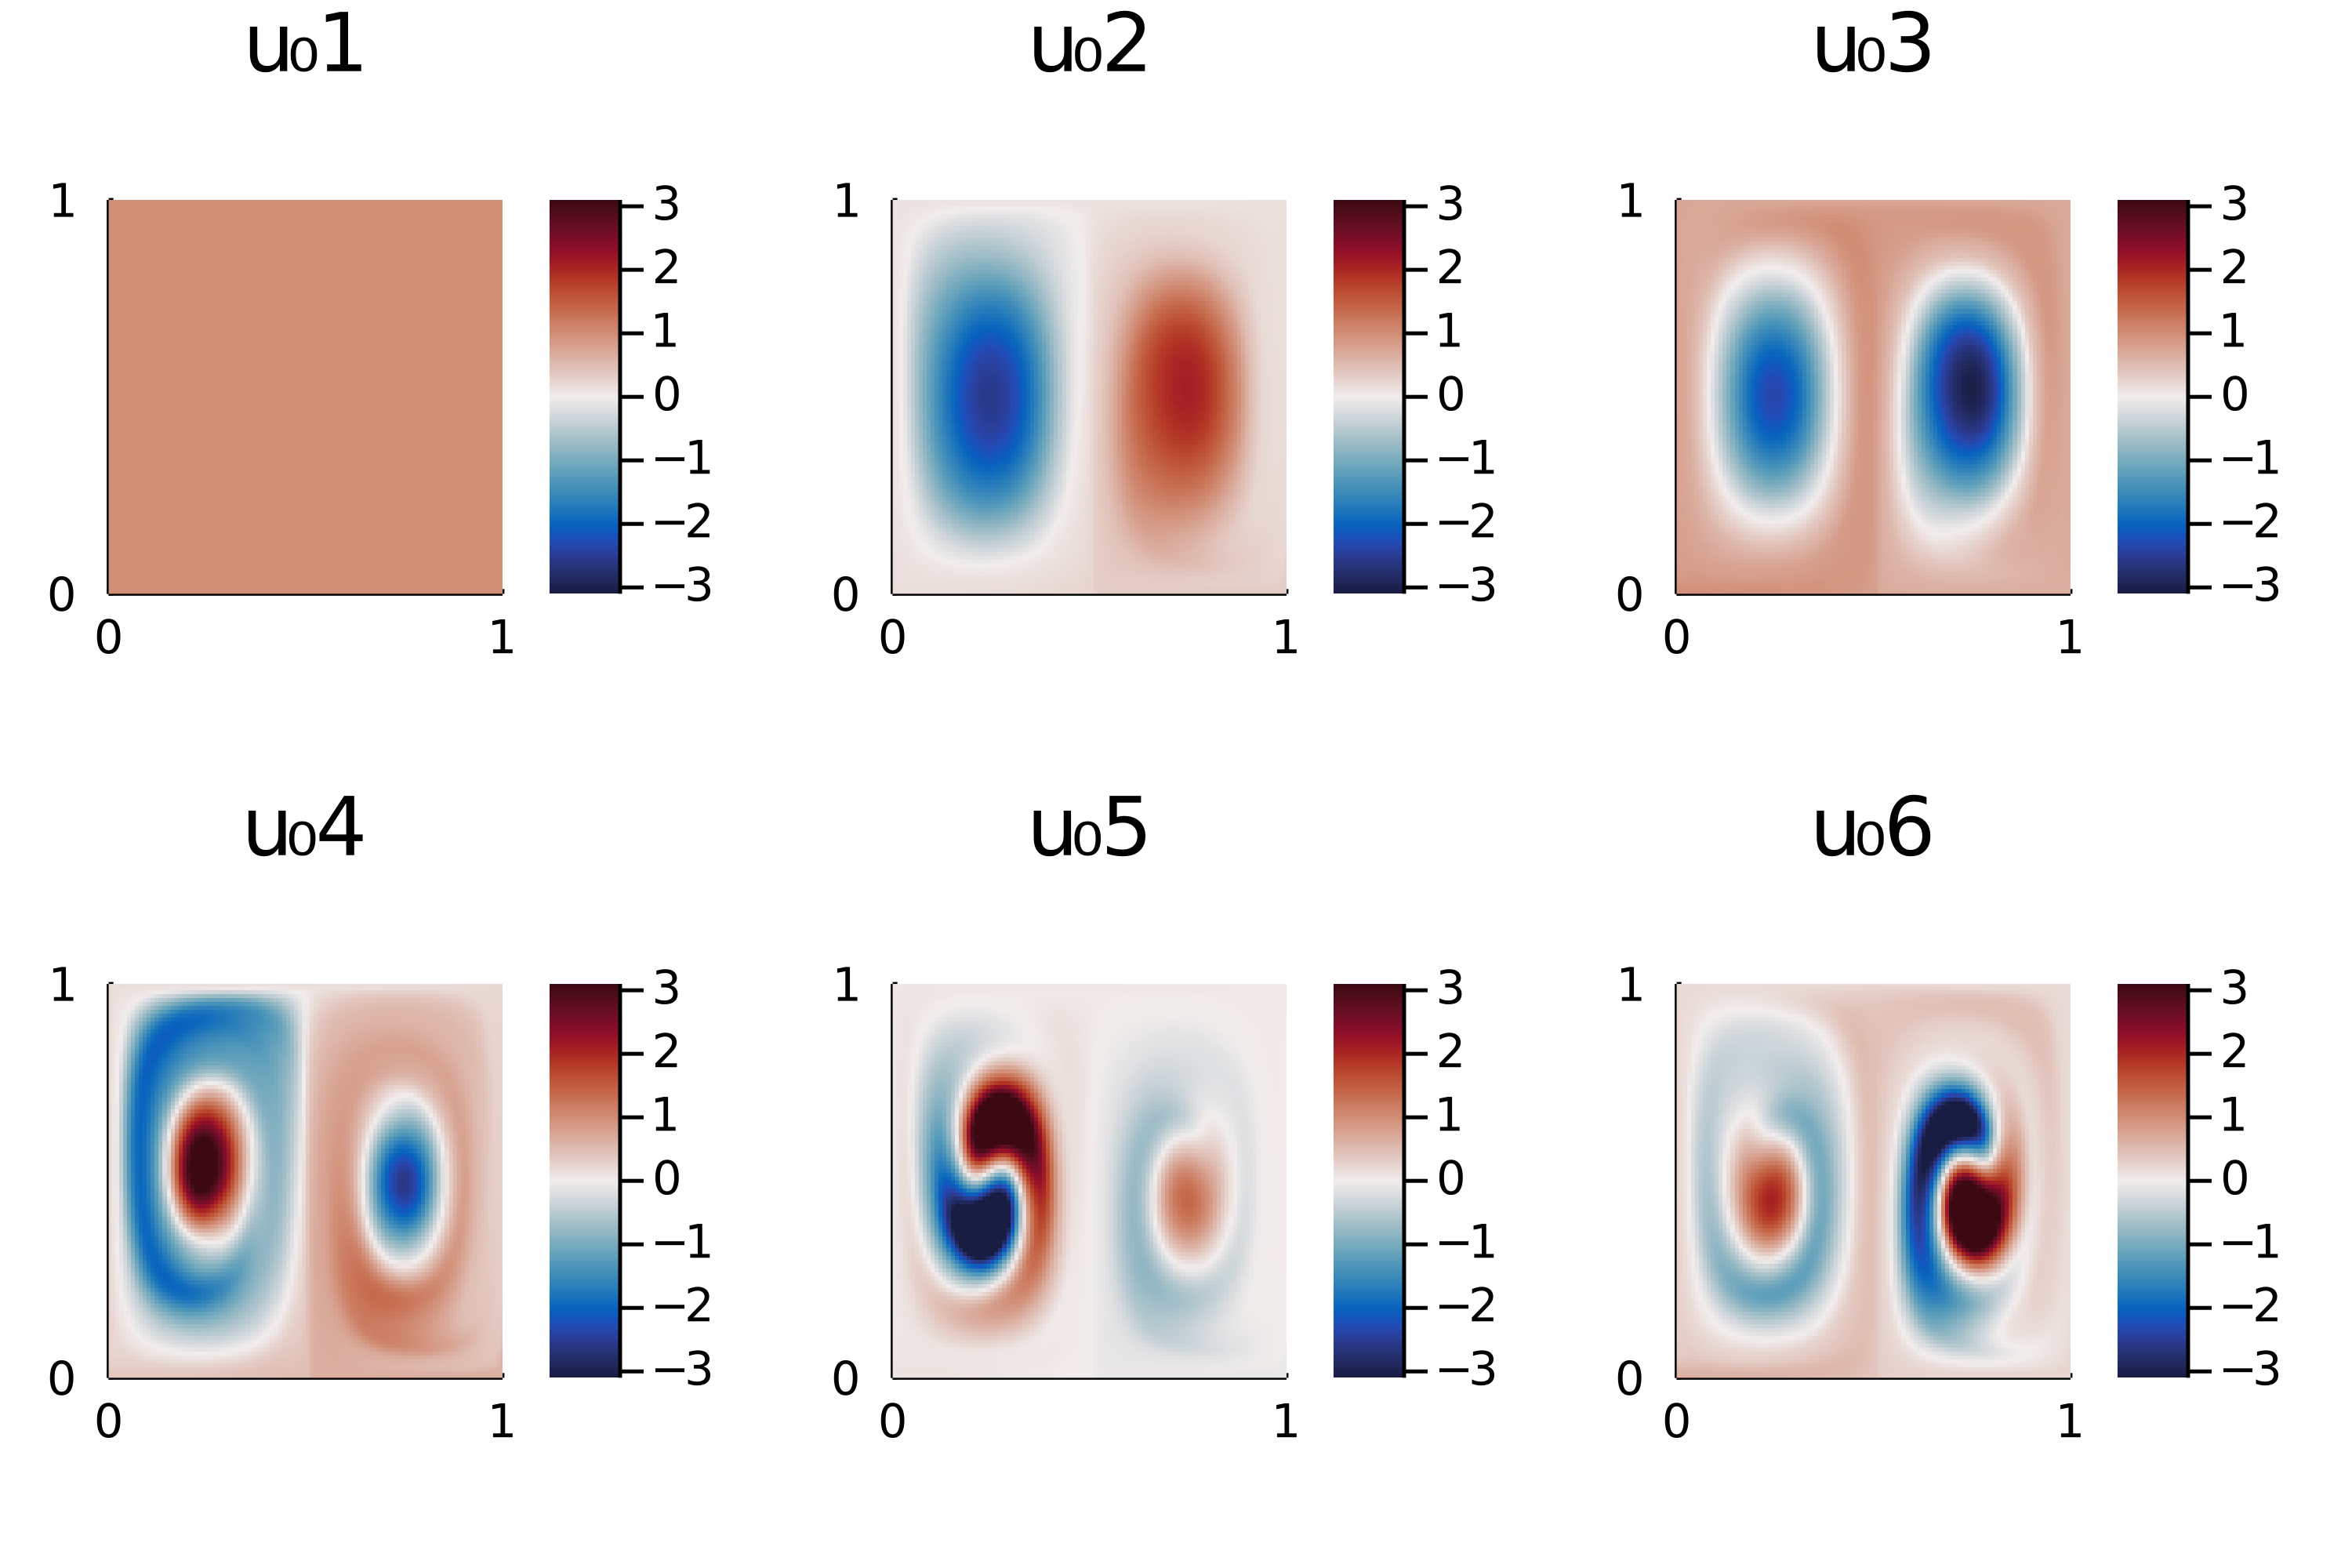

In [38]:
first         = plot_u(ctx, uϵs[:,1],  grid_resolution, grid_resolution, title="u₀1", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, uϵs[:,2],  grid_resolution, grid_resolution, title="u₀2", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, uϵs[:,3],  grid_resolution, grid_resolution, title="u₀3", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, uϵs[:,4],  grid_resolution, grid_resolution, title="u₀4", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, uϵs[:,5],  grid_resolution, grid_resolution, title="u₀5", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, uϵs[:,6],  grid_resolution, grid_resolution, title="u₀6", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

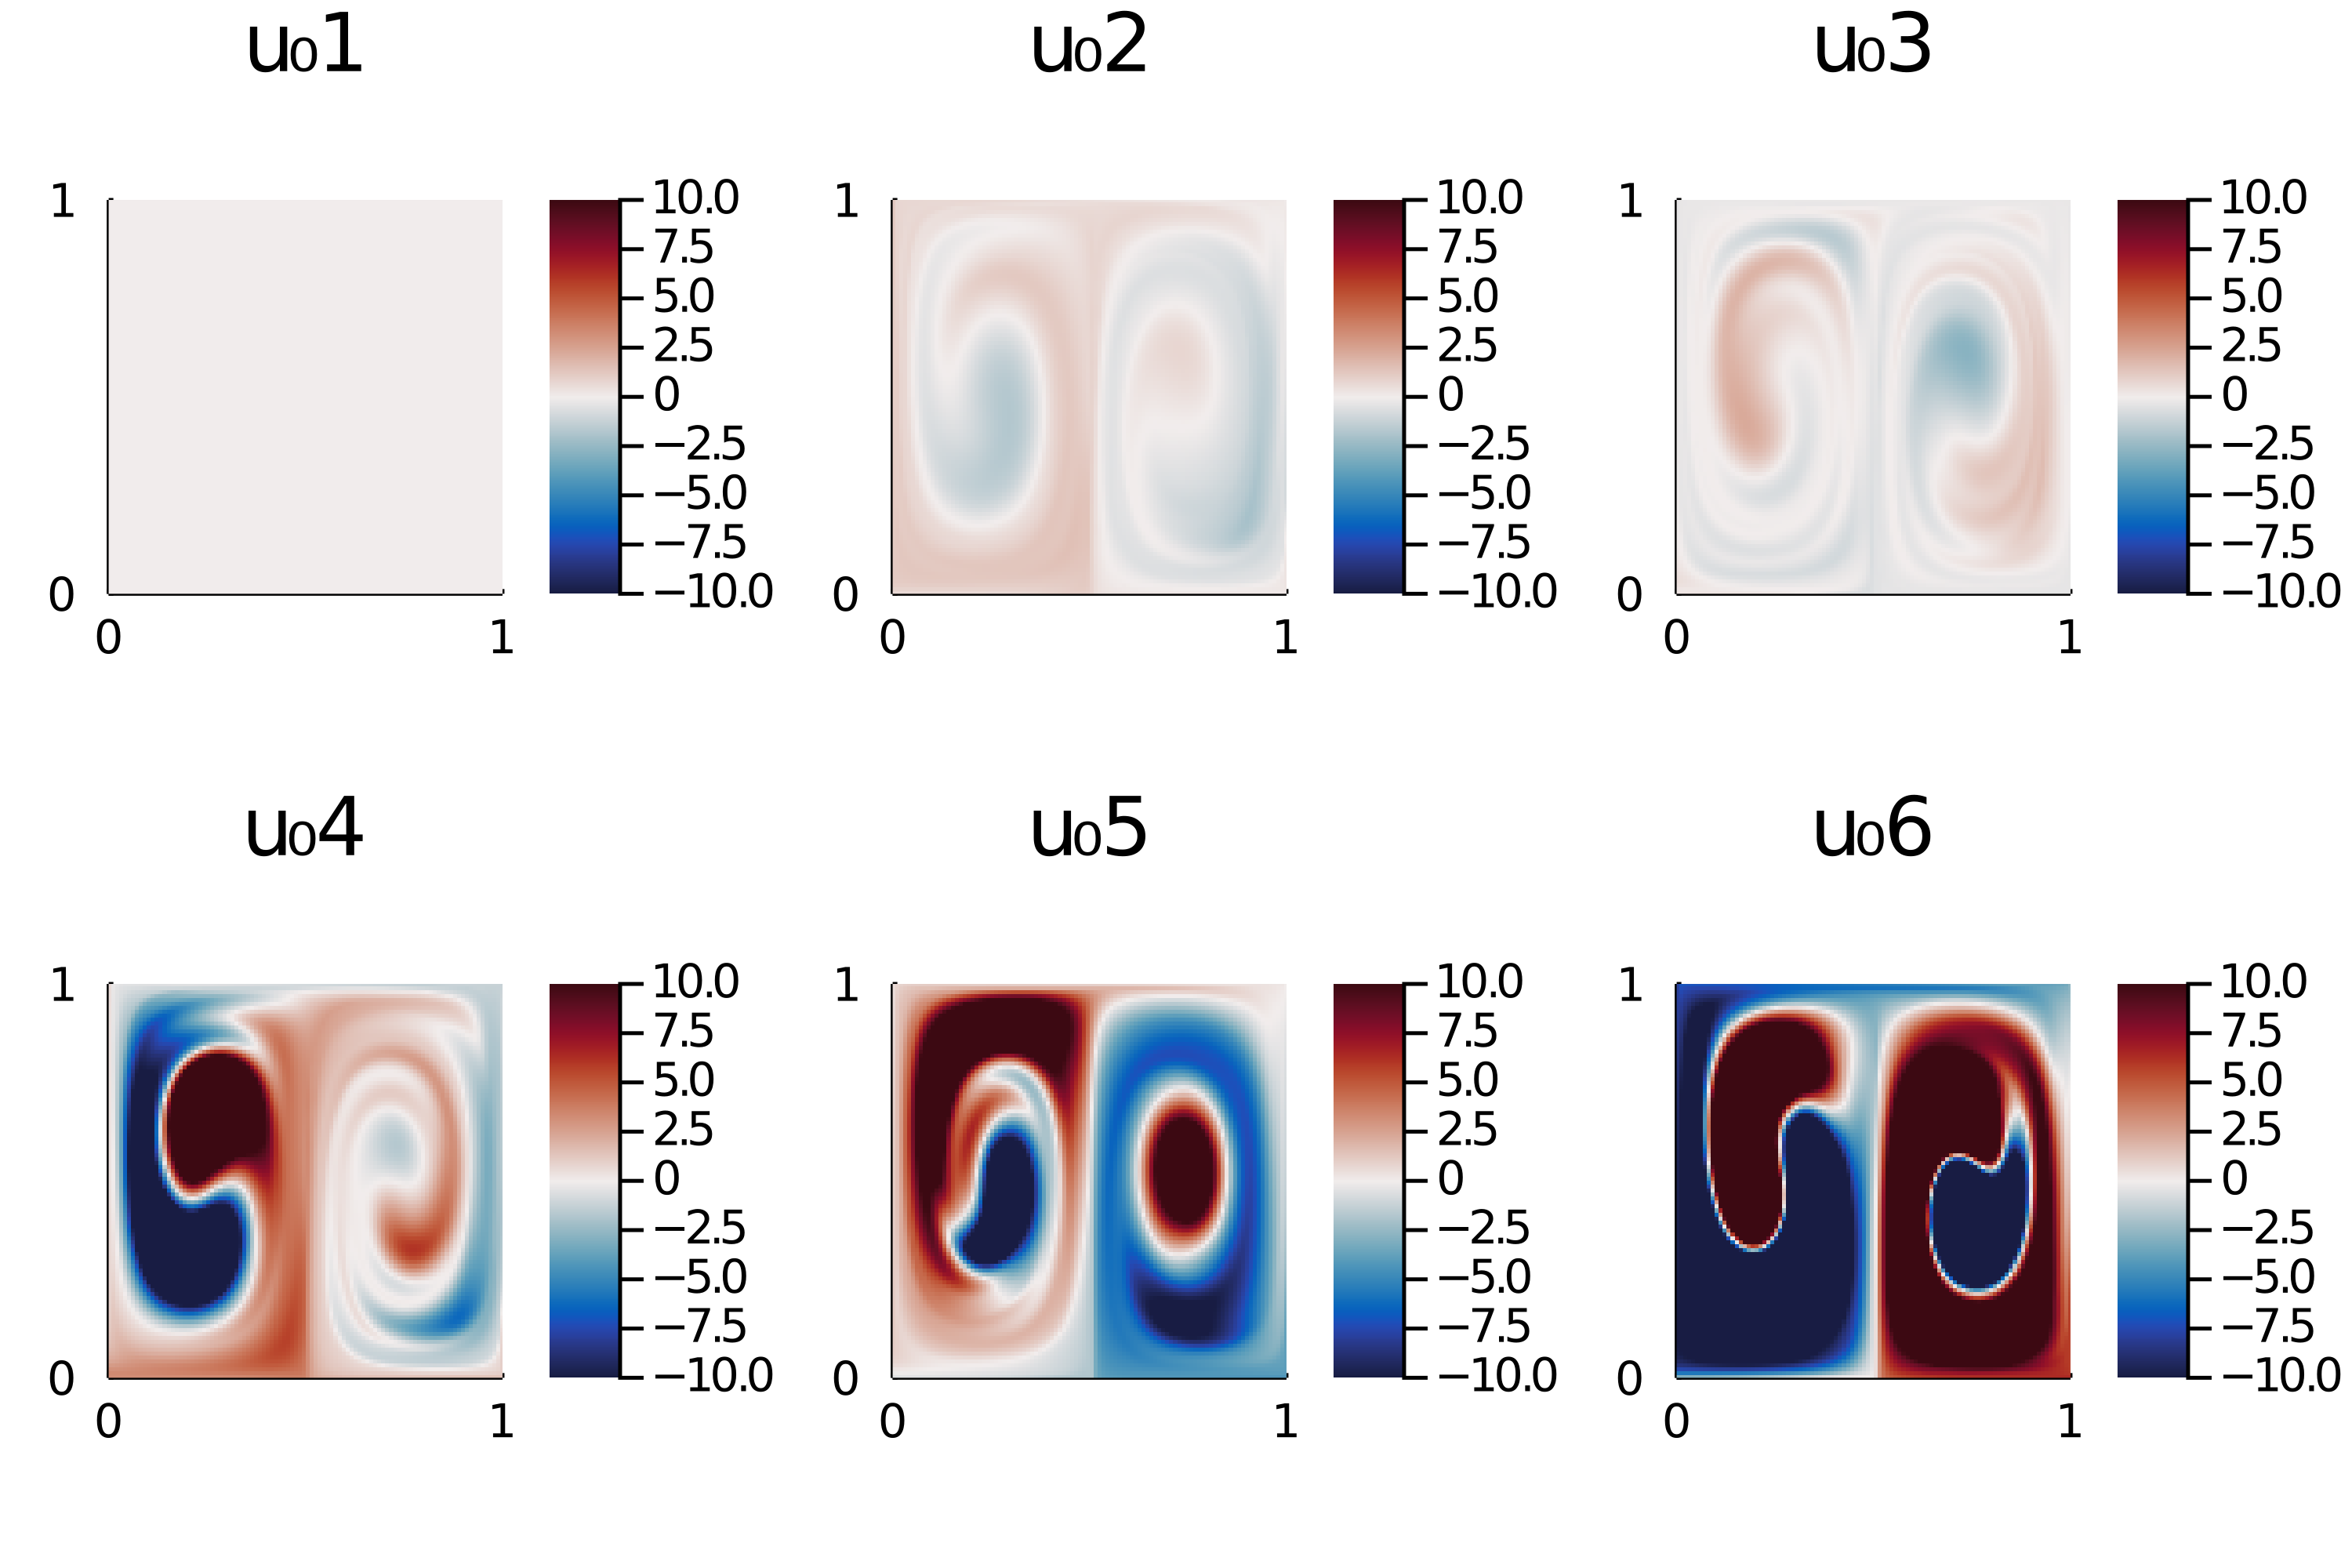

In [41]:
first         = plot_u(ctx, u_dots[1],  grid_resolution, grid_resolution, title="u₀1", 
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, u_dots[2],  grid_resolution, grid_resolution, title="u₀2", 
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, u_dots[3],  grid_resolution, grid_resolution, title="u₀3", 
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, u_dots[4],  grid_resolution, grid_resolution, title="u₀4", 
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, u_dots[5],  grid_resolution, grid_resolution, title="u₀5", 
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, u_dots[6],  grid_resolution, grid_resolution, title="u₀6", 
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

In [42]:
S = SEBA(u₀s)

10000×6 Array{Float64,2}:
 -0.0  -0.0  0.40325   -0.0  -0.0  0.0
 -0.0  -0.0  0.403265  -0.0  -0.0  0.0
 -0.0  -0.0  0.373826  -0.0  -0.0  0.0
 -0.0  -0.0  0.373763  -0.0  -0.0  0.0
 -0.0  -0.0  0.403308  -0.0  -0.0  0.0
 -0.0  -0.0  0.373574  -0.0  -0.0  0.0
 -0.0  -0.0  0.403381  -0.0  -0.0  0.0
 -0.0  -0.0  0.373269  -0.0  -0.0  0.0
 -0.0  -0.0  0.403483  -0.0  -0.0  0.0
 -0.0  -0.0  0.372851  -0.0  -0.0  0.0
 -0.0  -0.0  0.403619  -0.0  -0.0  0.0
 -0.0  -0.0  0.372328  -0.0  -0.0  0.0
 -0.0  -0.0  0.403786  -0.0  -0.0  0.0
  ⋮                                ⋮
 -0.0   0.0  0.280041  -0.0  -0.0  0.0
 -0.0   0.0  0.280414  -0.0  -0.0  0.0
 -0.0   0.0  0.280741  -0.0  -0.0  0.0
 -0.0   0.0  0.28104   -0.0  -0.0  0.0
 -0.0   0.0  0.28143   -0.0  -0.0  0.0
 -0.0   0.0  0.282231  -0.0  -0.0  0.0
 -0.0   0.0  0.28369   -0.0  -0.0  0.0
 -0.0   0.0  0.285106  -0.0  -0.0  0.0
 -0.0   0.0  0.286738  -0.0  -0.0  0.0
 -0.0   0.0  0.288707  -0.0  -0.0  0.0
 -0.0   0.0  0.29227   -0.0  -0.0  0.0
 

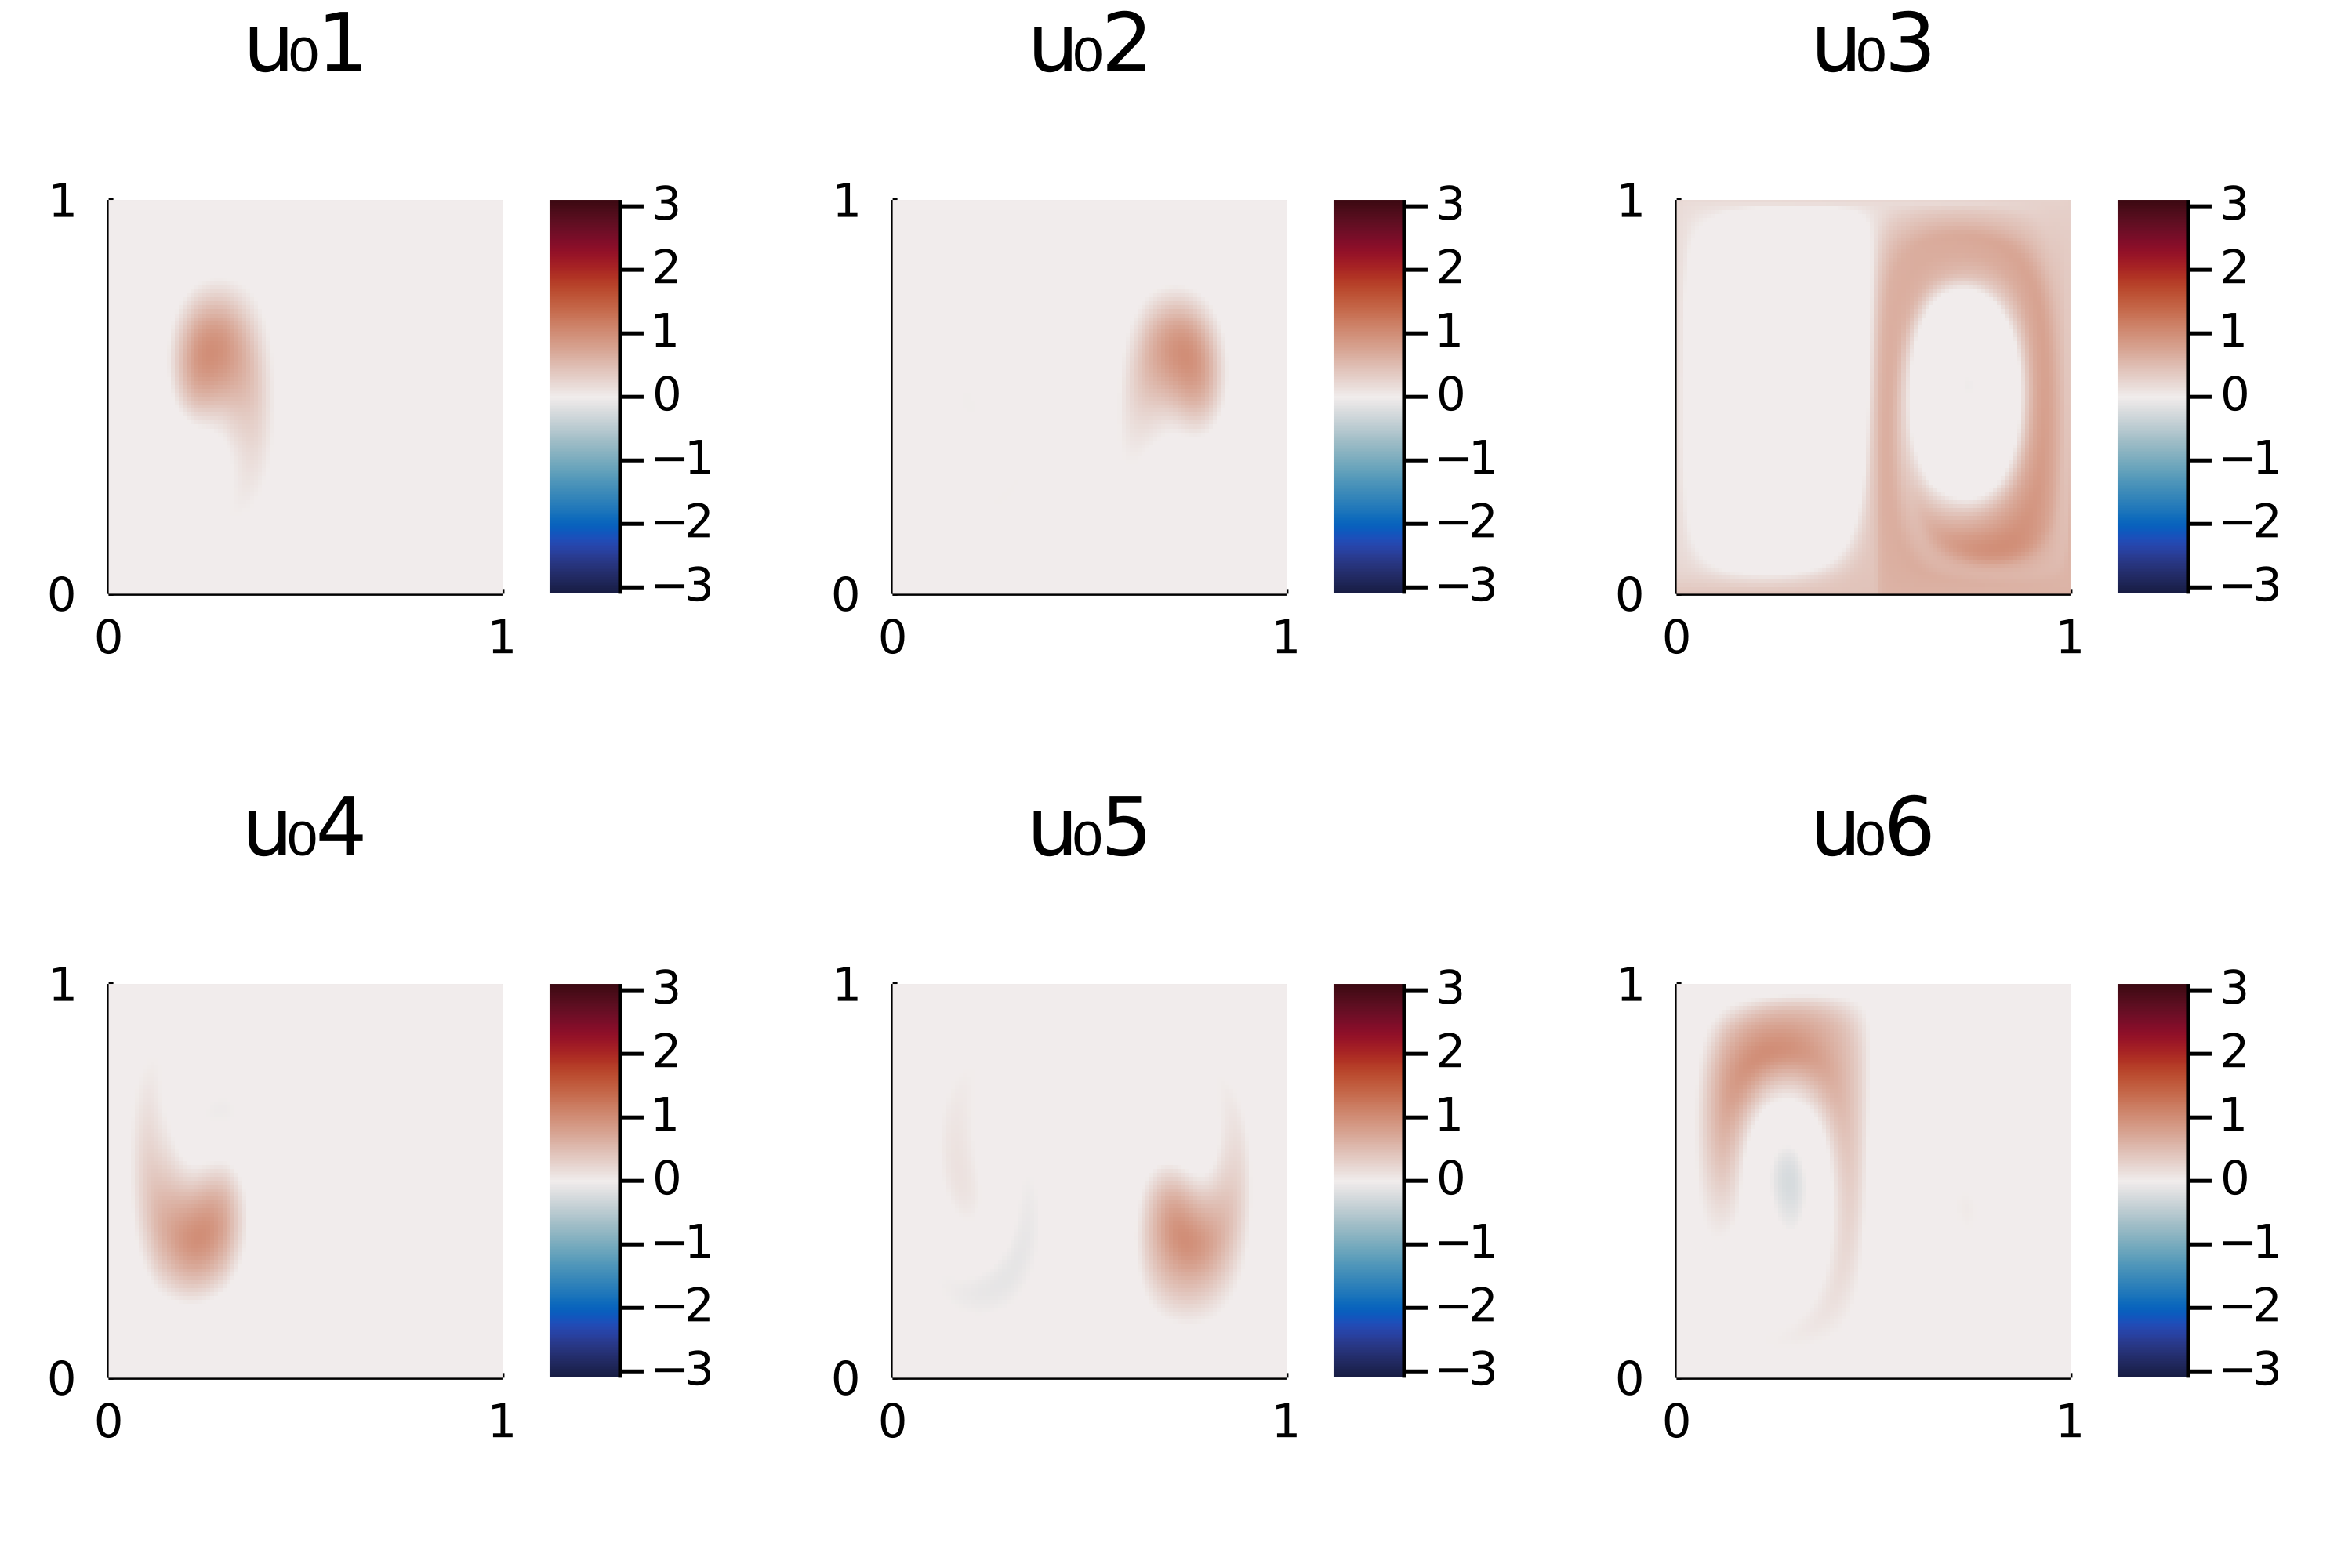

In [43]:
first         = plot_u(ctx, S[:,1],  grid_resolution, grid_resolution, title="u₀1", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, S[:,2],  grid_resolution, grid_resolution, title="u₀2", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, S[:,3],  grid_resolution, grid_resolution, title="u₀3", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, S[:,4],  grid_resolution, grid_resolution, title="u₀4", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, S[:,5],  grid_resolution, grid_resolution, title="u₀5", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, S[:,6],  grid_resolution, grid_resolution, title="u₀6", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

In [44]:
Sϵ = SEBA(uϵs)

10000×6 Array{Float64,2}:
  0.0  -0.0  0.0  -0.0  0.0  0.973576
  0.0  -0.0  0.0  -0.0  0.0  0.973624
  0.0  -0.0  0.0  -0.0  0.0  0.949436
  0.0  -0.0  0.0  -0.0  0.0  0.949374
  0.0  -0.0  0.0  -0.0  0.0  0.973578
  0.0  -0.0  0.0  -0.0  0.0  0.949242
  0.0  -0.0  0.0  -0.0  0.0  0.973438
  0.0  -0.0  0.0  -0.0  0.0  0.949027
  0.0  -0.0  0.0  -0.0  0.0  0.973206
  0.0  -0.0  0.0  -0.0  0.0  0.948708
  0.0  -0.0  0.0  -0.0  0.0  0.972882
  0.0  -0.0  0.0  -0.0  0.0  0.948258
  0.0  -0.0  0.0  -0.0  0.0  0.972469
  ⋮                          ⋮
 -0.0  -0.0  0.0  -0.0  0.0  0.458152
 -0.0  -0.0  0.0  -0.0  0.0  0.459879
 -0.0  -0.0  0.0  -0.0  0.0  0.461317
 -0.0  -0.0  0.0  -0.0  0.0  0.462343
 -0.0  -0.0  0.0  -0.0  0.0  0.462455
 -0.0  -0.0  0.0  -0.0  0.0  0.462426
 -0.0  -0.0  0.0  -0.0  0.0  0.462451
 -0.0  -0.0  0.0  -0.0  0.0  0.46247
 -0.0  -0.0  0.0  -0.0  0.0  0.463097
 -0.0  -0.0  0.0  -0.0  0.0  0.463342
 -0.0  -0.0  0.0  -0.0  0.0  0.463897
 -0.0  -0.0  0.0  -0.0  0.0  0.4

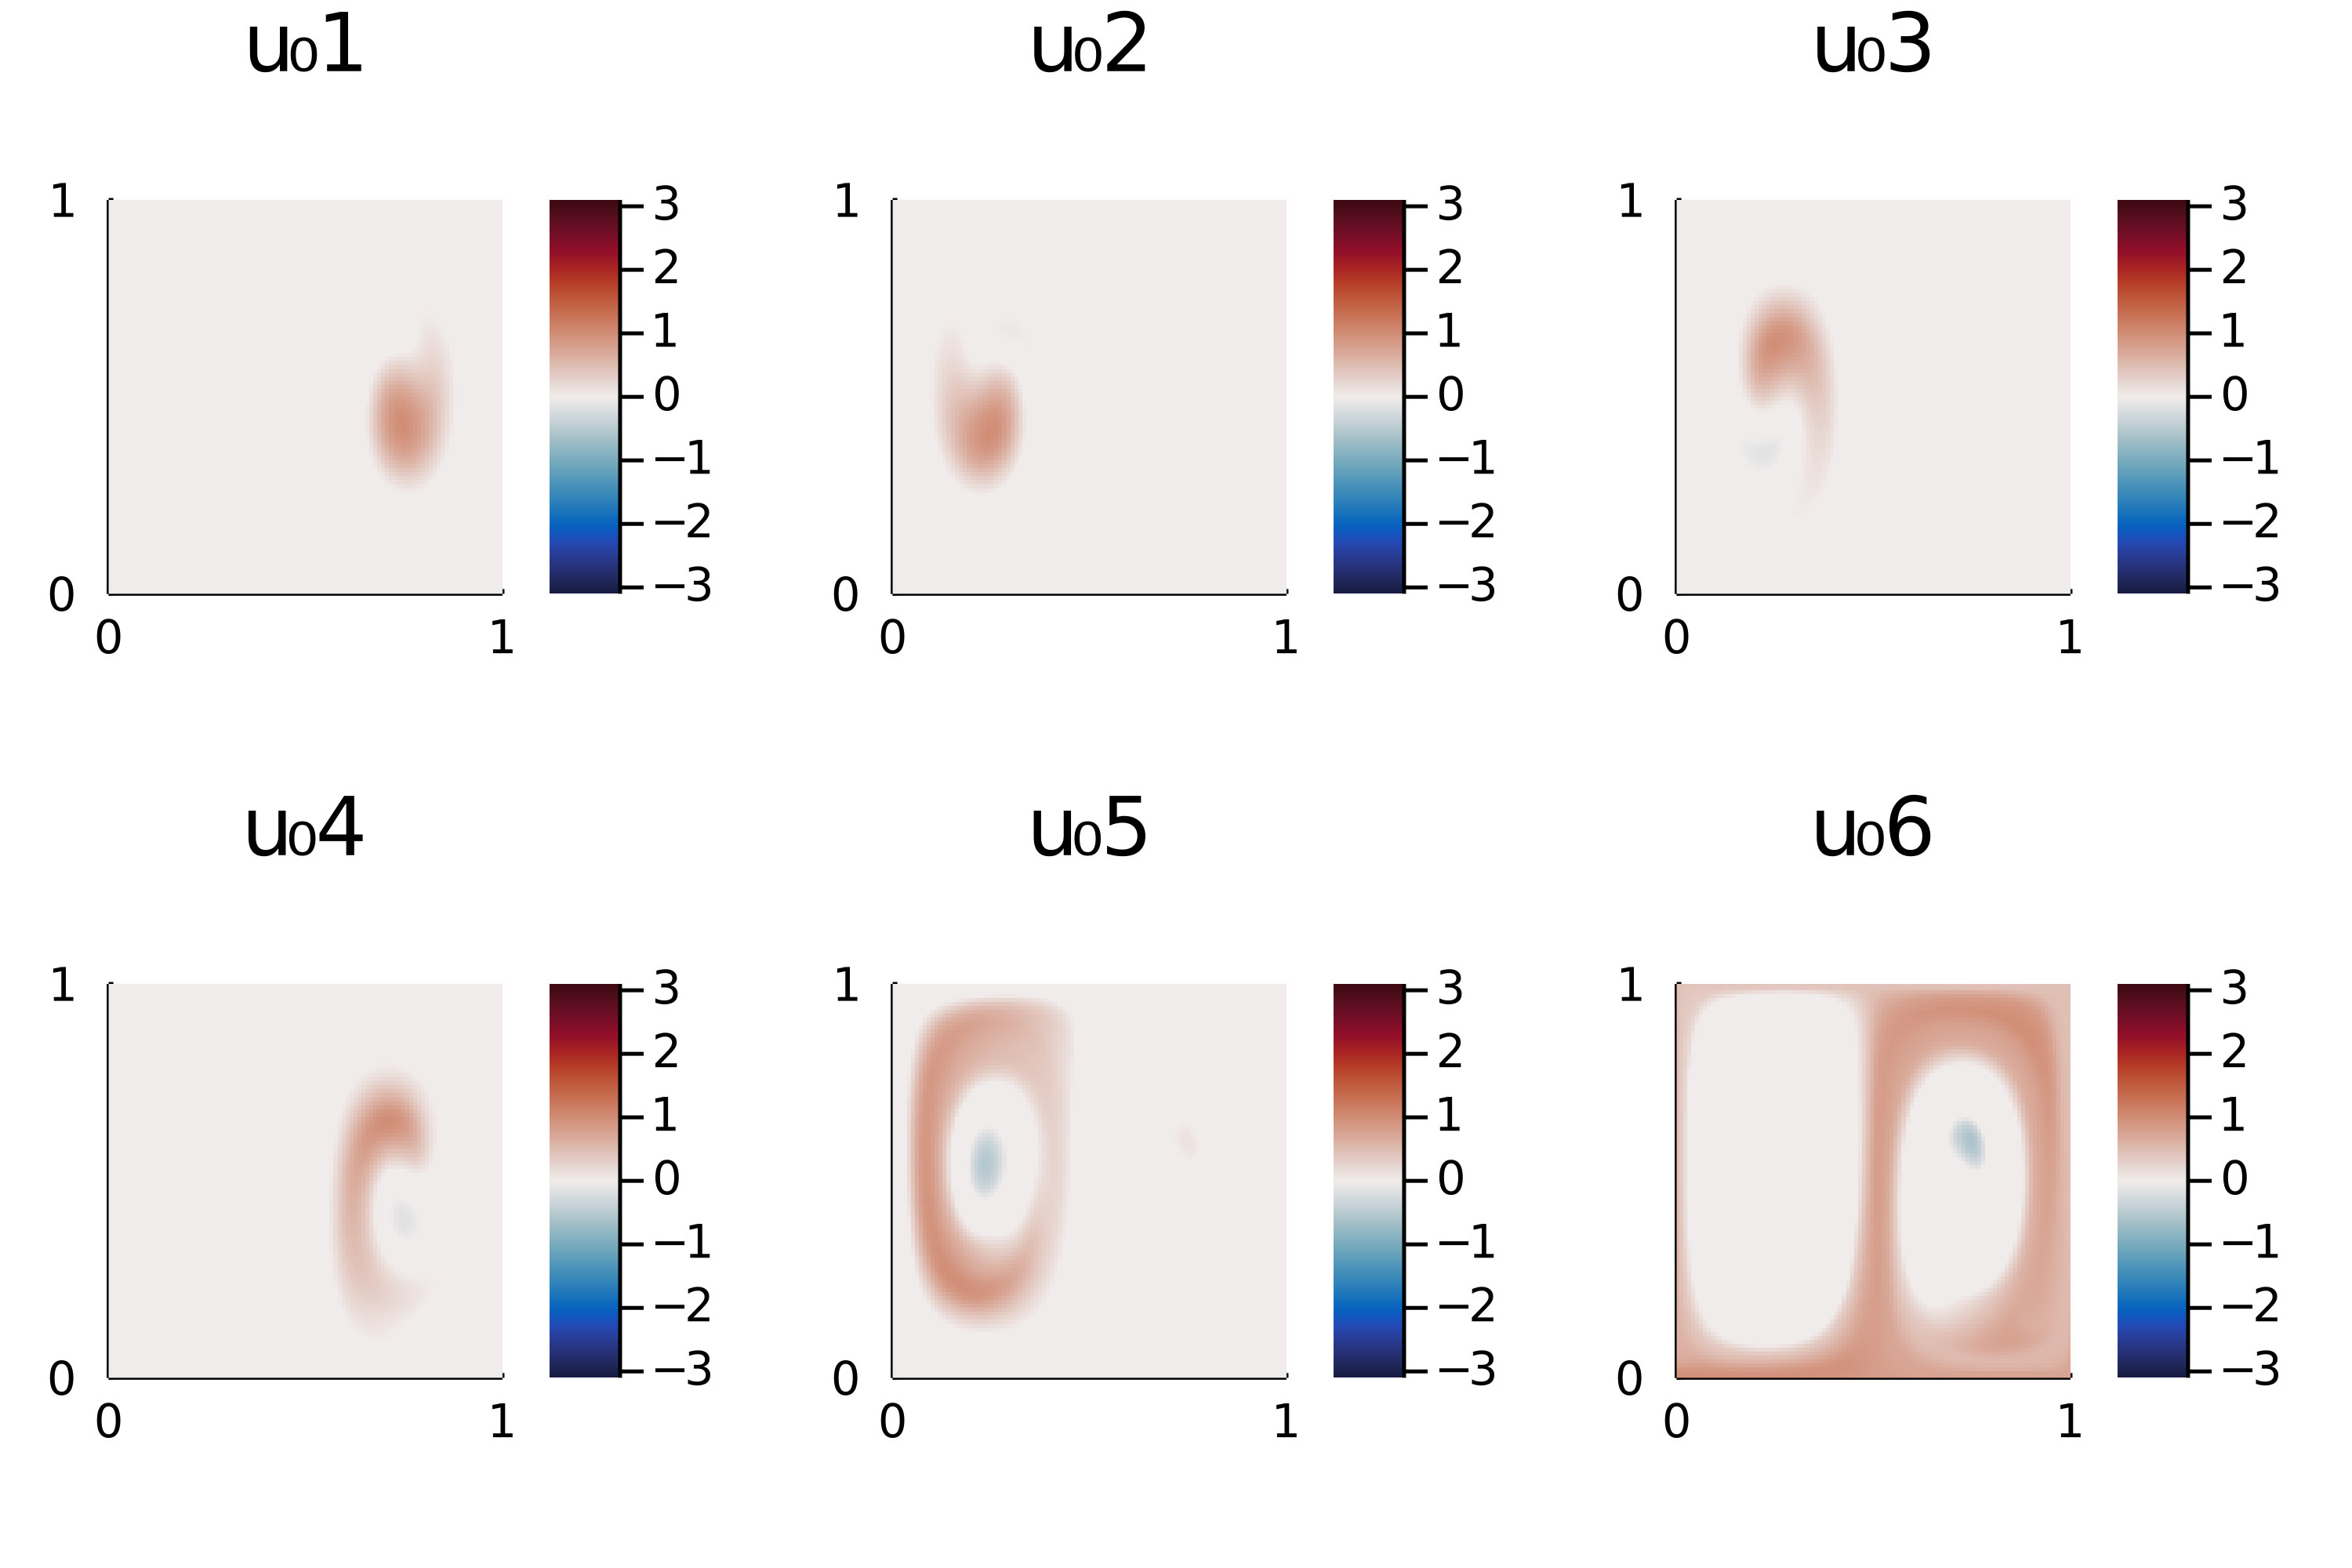

In [45]:
first         = plot_u(ctx, Sϵ[:,1],  grid_resolution, grid_resolution, title="u₀1", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, Sϵ[:,2],  grid_resolution, grid_resolution, title="u₀2", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, Sϵ[:,3],  grid_resolution, grid_resolution, title="u₀3", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, Sϵ[:,4],  grid_resolution, grid_resolution, title="u₀4", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, Sϵ[:,5],  grid_resolution, grid_resolution, title="u₀5", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, Sϵ[:,6],  grid_resolution, grid_resolution, title="u₀6", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)